In [1]:
import os
os.chdir(os.path.expanduser("~/Projects/zimmer"))
import copy
import pickle

import numpy as np
np.random.seed(1234)

import matplotlib.pyplot as plt
plt.ion()

from tqdm import tqdm
from functools import partial

from zimmer.io import load_kato_data
import zimmer.plotting as zplt

from ssm.models import HMM, SLDS, LDS
from ssm.util import find_permutation, compute_state_overlap
from ssm.preprocessing import pca_with_imputation, trend_filter

In [2]:
# Load the data
ys, ms, z_trues, z_true_key, neuron_names = load_kato_data(include_unnamed=False, signal="dff")
ys = [trend_filter(y) for y in ys]

K_true = len(z_true_key)
N = ys[0].shape[1]
W = len(ys)
Ts = [y.shape[0] for y in ys]

Only including named neurons.
59 neurons across all 5 worms


In [3]:
K = 8
D = 4

In [4]:
# Run PCA to get a 3d projection of the data
from scipy.ndimage import gaussian_filter1d
from ssm.preprocessing import pca_with_imputation
pca, xs = pca_with_imputation(D, ys, ms)
xs = [gaussian_filter1d(x, 1, axis=0) for x in xs]
dxs = [gaussian_filter1d(np.gradient(x, axis=0), 1, axis=0) for x in xs]

Text(0.5,0.98,'Continuous Latent States (Zimmer Labels)')

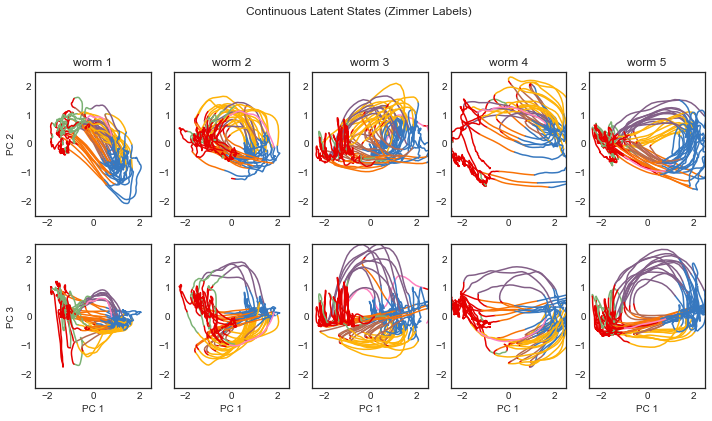

In [5]:
plt.figure(figsize=(12, 9))
for w, (x, z) in enumerate(zip(xs, z_trues)):
    ax = plt.subplot(3, W, w+1)
    zplt.plot_2d_continuous_states(x, z, xlims=(-2.5, 2.5), ylims=(-2.5, 2.5), inds=(0, 1), ax=ax)
    plt.ylabel("PC 2" if w == 0 else "")
    plt.title("worm {}".format(w+1))

    ax = plt.subplot(3, W, W+w+1)
    zplt.plot_2d_continuous_states(x, z, xlims=(-2.5, 2.5), ylims=(-2.5, 2.5), inds=(0, 2), ax=ax)
    plt.ylabel("PC 3" if w == 0 else "")
    plt.xlabel("PC 1")
    
plt.suptitle("Continuous Latent States (Zimmer Labels)")

# Fit an ARHMM to the continuous latent states

In [6]:
hmm = HMM(K, D, M=0, transitions="recurrent", observations="ar")

In [7]:
lls = hmm.fit(xs, method="em", num_em_iters=50, num_iters=20, tags=list(range(5)))

Iteration 0.  LL: 136540.9
Iteration 1.  LL: 138711.3
Iteration 2.  LL: 139788.3
Iteration 3.  LL: 140729.5
Iteration 4.  LL: 141746.9
Iteration 5.  LL: 142307.1
Iteration 6.  LL: 142535.8
Iteration 7.  LL: 142748.2
Iteration 8.  LL: 142936.6
Iteration 9.  LL: 143032.2
Iteration 10.  LL: 143104.1
Iteration 11.  LL: 143152.1
Iteration 12.  LL: 143215.9
Iteration 13.  LL: 143235.4
Iteration 14.  LL: 143258.9
Iteration 15.  LL: 143306.9
Iteration 16.  LL: 143333.1
Iteration 17.  LL: 143374.4
Iteration 18.  LL: 143397.5
Iteration 19.  LL: 143432.1
Iteration 20.  LL: 143441.7
Iteration 21.  LL: 143457.2
Iteration 22.  LL: 143480.3
Iteration 23.  LL: 143532.5
Iteration 24.  LL: 143534.7
Iteration 25.  LL: 143555.5
Iteration 26.  LL: 143540.1
Iteration 27.  LL: 143537.4
Iteration 28.  LL: 143548.8
Iteration 29.  LL: 143545.5
Iteration 30.  LL: 143555.8
Iteration 31.  LL: 143557.2
Iteration 32.  LL: 143560.9
Iteration 33.  LL: 143590.0
Iteration 34.  LL: 143593.5
Iteration 35.  LL: 143584.6
It

In [8]:
z_infs = [hmm.most_likely_states(x, tag=tag) for tag, x in enumerate(xs)]
hmm.permute(find_permutation(np.concatenate(z_trues), np.concatenate(z_infs)))
z_infs = [hmm.most_likely_states(x, tag=tag) for tag, x in enumerate(xs)]

In [9]:
np.bincount(np.concatenate(z_infs), minlength=8)

array([2316, 3866, 1285, 2874, 1329, 1676, 1417, 1433])

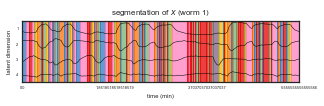

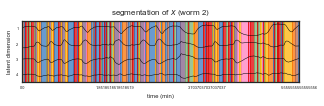

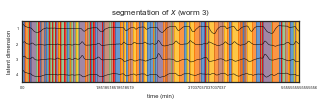

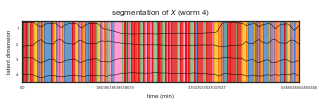

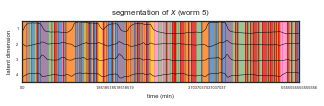

In [10]:
zplt.plot_latent_trajectories_vs_time(xs, z_infs, plot_slice=(0, 1000))

Text(0.5,0.98,'Continuous Latent States (Inferred Labels)')

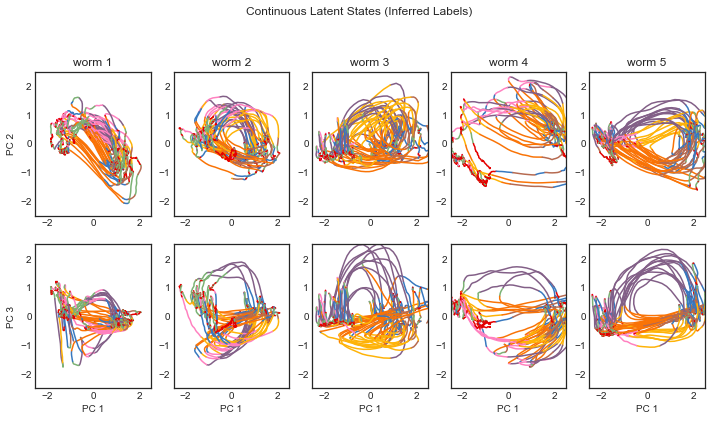

In [11]:
plt.figure(figsize=(12, 9))
for w, (x, z) in enumerate(zip(xs, z_infs)):
    ax = plt.subplot(3, W, w+1)
    zplt.plot_2d_continuous_states(x, z, xlims=(-2.5, 2.5), ylims=(-2.5, 2.5), inds=(0, 1), ax=ax)
    plt.ylabel("PC 2" if w == 0 else "")
    plt.title("worm {}".format(w+1))

    ax = plt.subplot(3, W, W+w+1)
    zplt.plot_2d_continuous_states(x, z, xlims=(-2.5, 2.5), ylims=(-2.5, 2.5), inds=(0, 2), ax=ax)
    plt.ylabel("PC 3" if w == 0 else "")
    plt.xlabel("PC 1")
    
plt.suptitle("Continuous Latent States (Inferred Labels)")

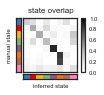

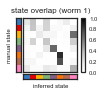

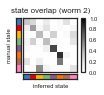

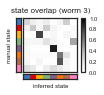

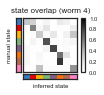

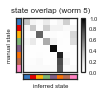

In [12]:
zplt.plot_state_overlap(z_infs, z_trues)

In [13]:
np.linalg.eigvals(hmm.observations.As).round(2)

array([[1.09+0.j  , 1.  +0.j  , 0.97+0.02j, 0.97-0.02j],
       [1.  +0.j  , 1.  +0.j  , 0.99+0.j  , 0.99-0.j  ],
       [0.97+0.07j, 0.97-0.07j, 0.95+0.j  , 1.01+0.j  ],
       [0.97+0.j  , 0.99+0.01j, 0.99-0.01j, 1.  +0.j  ],
       [0.96+0.07j, 0.96-0.07j, 1.03+0.j  , 1.03-0.j  ],
       [0.98+0.05j, 0.98-0.05j, 0.98+0.j  , 0.9 +0.j  ],
       [1.01+0.04j, 1.01-0.04j, 0.97+0.j  , 1.  +0.j  ],
       [0.97+0.01j, 0.97-0.01j, 1.  +0.01j, 1.  -0.01j]])

# Simulate from an HMM, reducing the dynamics noise

In [14]:
hmm_low_noise = copy.deepcopy(hmm)
hmm_low_noise.observations.inv_sigmas -= 2

In [15]:
pad = 3
Tsmpl = 1000
i = 1
zpre, xpre = z_infs[i][-pad:], xs[i][-pad:]
zsmpl, xsmpl = hmm_low_noise.sample(Tsmpl, prefix=(zpre, xpre), tag=i, with_noise=True)

zfull = np.concatenate((zpre, zsmpl))
xfull = np.concatenate((xpre, xsmpl))

Text(0.5,0,'time (s)')

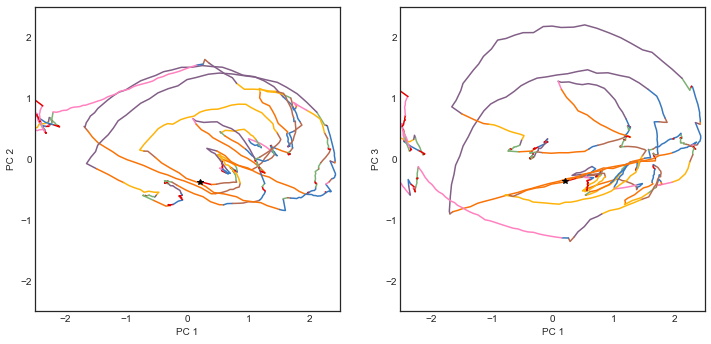

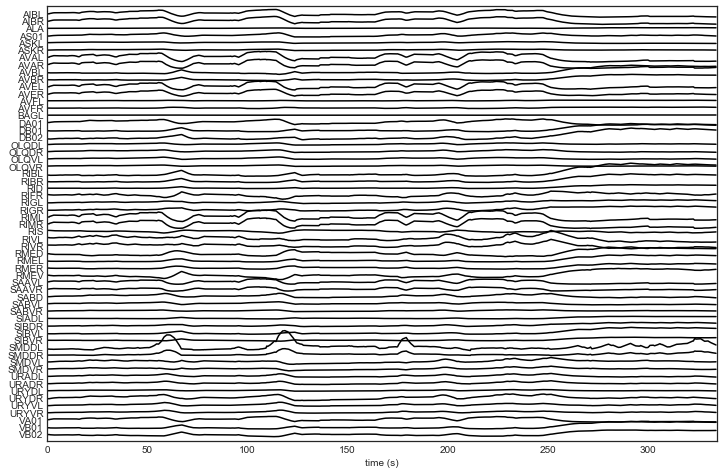

In [28]:
plt.figure(figsize=(12, 6))
ax = plt.subplot(1, 2, 1, aspect="equal")
zplt.plot_2d_continuous_states(xfull, zfull, xlims=(-2.5, 2.5), ylims=(-2.5, 2.5), inds=(0, 1), ax=ax)
plt.plot(xfull[pad-1,0], xfull[pad-1,1], 'k*')
plt.xlabel("PC 1")
plt.ylabel("PC 2")

ax = plt.subplot(1, 2, 2, aspect="equal")
zplt.plot_2d_continuous_states(xfull, zfull, xlims=(-2.5, 2.5), ylims=(-2.5, 2.5), inds=(0, 2), ax=ax)
plt.plot(xfull[pad-1,0], xfull[pad-1,2], 'k*')
plt.xlabel("PC 1")
plt.ylabel("PC 3")

plt.figure(figsize=(12, 8))
ysim = xfull.dot(pca.components_) + pca.mean_
plt.plot(np.arange(ysim.shape[0]) / 3.0, ysim - np.arange(N), '-k')
plt.yticks(-np.arange(N), neuron_names)
plt.ylim(-N,1)
plt.xlim(0, ysim.shape[0] / 3.0)
plt.xlabel("time (s)")